# 프로젝트 : mini BERT 만들기

[하이퍼파라미터 조정 전략]
현재 모델은 과소적합(Underfitting) 상태, 즉 아직 데이터로부터 충분한 패턴을 배우지 못한 상태에 가깝습니다. 이를 해결하기 위한 주요 조정 방향은 다음과 같습니다.

1. 학습률(Learning Rate) 높이기 (가장 중요):
- 문제: 현재 설정된 1e-4의 학습률은 모델이 너무 조심스럽게 학습하게 만들어, 10 Epoch라는 짧은 기간 동안 최적점에 도달하기 어려웠을 수 있습니다.
- 해결책: 학습률을 약간 높여 모델이 더 과감하게 가중치를 업데이트하도록 합니다. 일반적으로 BERT와 같은 모델의 사전 학습에는 1e-4에서 5e-4 사이의 값이 자주 사용됩니다. 3e-4 정도로 상향 조정하여 실험해 보겠습니다.

2. 학습 기간(Epochs) 늘리기:
- 문제: BERT 사전 학습은 매우 많은 계산을 요구하며, 10 Epoch는 언어의 복잡성을 배우기에 절대적으로 부족한 시간입니다.
- 해결책: 학습 기간을 최소 30 Epoch 이상으로 대폭 늘려 모델이 데이터 패턴을 충분히 학습할 시간을 줍니다. Loss가 수렴하는 추세를 보며 더 늘릴 수도 있습니다.

3. 모델 구조(Architecture) 최적화:
- 문제: 파라미터 수가 비슷한 모델이라도 구조(깊이 vs 너비)에 따라 성능이 달라질 수 있습니다.
- 해결책: 이전 비교에서 성능이 가장 좋았던 '얕고 넓은 모델(Shallow & Wide)' 구조 (d_model=112, n_layer=2)를 채택하여 학습 효율을 높입니다.

In [2]:
!pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.2 MB/s eta 0:00:00


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import sentencepiece as spm
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# 재현성을 위한 Random seed 설정
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

print("Torch 버전:", torch.__version__)

Torch 버전: 2.7.1+cu118


## 1. 토크나이저(Tokenizer) 준비
- SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만듭니다.
- 한글 나무 위키 코퍼스(`kowiki.txt`)로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만듭니다.
- BERT에 사용되는 주요 특수문자가 vocab에 포함되도록 합니다: `[PAD], [UNK], [BOS], [EOS], [SEP], [CLS], [MASK]`

In [5]:
pwd

'/home/jovyan/work/bert_pretrain'

In [6]:
corpus_file = 'data/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

if not os.path.exists(f'{prefix}.model'):
    spm.SentencePieceTrainer.train(
        f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}"
        f" --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD]"
        f" --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3"
        f" --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]"
    )

vocab = spm.SentencePieceProcessor()
vocab.load(f"{prefix}.model")

vocab_list = []
for i in range(7, len(vocab)):
    if not vocab.is_unknown(i):
        vocab_list.append(vocab.id_to_piece(i))

## 2. 데이터 전처리 (1) MASK 생성
- BERT의 MLM(Masked Language Model)에 필요한 빈칸(mask)을 생성하는 함수를 정의합니다.
- 학습 데이터 전체 토큰의 15%를 마스킹합니다.
- 마스킹 전략: 80%는 `[MASK]` 토큰으로, 10%는 랜덤 토큰으로, 10%는 원래 토큰을 그대로 사용합니다.

In [7]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            continue
        if token.startswith(u" "):
            cand_idx.append([i])
        else:
            if cand_idx:
                cand_idx[-1].append(i)
    random.shuffle(cand_idx)

    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        
        dice = random.random()
        for index in index_set:
            masked_token = None
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9:
                masked_token = tokens[index]
            else:
                masked_token = random.choice(vocab_list)
            
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

## 3. 데이터 전처리 (2) NSP pair 생성
- BERT의 pretrain 과제인 NSP(Next Sentence Prediction)를 위한 데이터 쌍을 생성하는 함수를 정의합니다.
- 50%의 확률로 실제 이어지는 문장(is_next=1)과 랜덤으로 추출된 문장(is_next=0)을 쌍으로 만듭니다.
- 문장 구분을 위해 세그먼트 임베딩 값(0 또는 1)을 부여합니다.

In [8]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    max_seq = n_seq - 3
    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        
        if i == len(doc) - 1 or current_length >= max_seq:
            if current_chunk:
                a_end = 1
                if len(current_chunk) > 1:
                    a_end = random.randrange(1, len(current_chunk))
                
                tokens_a = []
                for j in range(a_end):
                    tokens_a.extend(current_chunk[j])
                
                tokens_b = []
                is_next = 1 
                if len(current_chunk) > 1 and random.random() < 0.5:
                    is_next = 0 
                    temp = tokens_a
                    tokens_a = tokens_b
                    tokens_b = temp
                
                for j in range(a_end, len(current_chunk)):
                    tokens_b.extend(current_chunk[j])
                
                trim_tokens(tokens_a, tokens_b, max_seq)
                if not tokens_a or not tokens_b:
                    continue

                tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
                segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
                
                mask_cnt = int((len(tokens) - 3) * mask_prob)
                tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

                instance = {
                    "tokens": tokens,
                    "segment": segment,
                    "is_next": is_next,
                    "mask_idx": mask_idx,
                    "mask_label": mask_label
                }
                instances.append(instance)

            current_chunk = []
            current_length = 0
            
    return instances

## 4. 데이터 전처리 (3) 데이터셋 완성
- 위에서 정의한 함수들을 사용해 전체 `kowiki.txt` 코퍼스를 BERT pretrain 데이터셋으로 변환합니다.
- 생성된 데이터는 json 포맷으로 저장합니다.
- 대용량 데이터를 효율적으로 다루기 위해 `np.memmap`을 사용하여 데이터를 로드하는 함수를 정의합니다.

In [9]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ Pre-training 데이터를 생성하여 파일로 저장하는 함수 """
    
    vocab_list = [vocab.id_to_piece(i) for i in range(7, len(vocab)) if not vocab.is_unknown(i)]
    
    line_cnt = 0
    with open(in_file, "r") as f:
        for _ in f:
            line_cnt += 1

    with open(in_file, "r") as in_f, open(out_file, "w") as out_f:
        doc = []
        for line in tqdm(in_f, total=line_cnt, desc="데이터 생성 중"):
            line = line.strip()
            if not line: # 빈 줄이면 문단(doc) 처리
                if doc:
                    instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
                    for instance in instances:
                        out_f.write(json.dumps(instance, ensure_ascii=False))
                        out_f.write("\n")
                    doc = []
            else:
                pieces = vocab.encode_as_pieces(line)
                if pieces:
                    doc.append(pieces)
        
        if doc: # 파일 끝에 남은 doc 처리
            instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
            for instance in instances:
                out_f.write(json.dumps(instance, ensure_ascii=False))
                out_f.write("\n")


In [10]:
pretrain_json_path = 'bert_pre_train.json'
n_seq = 128

if not os.path.exists(pretrain_json_path):
    print("Pre-training data not found. Creating new data...")
    make_pretrain_data(vocab, corpus_file, pretrain_json_path, n_seq)
    print("Data generation complete.")
else:
    print("Pre-training data already exists. Skipping generation.")

def load_pre_train_data(vocab, filename, n_seq, count=None):
    line_total = 0
    with open(filename, "r") as f:
        for _ in f:
            line_total += 1

    total = count if count is not None and count < line_total else line_total
    
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total, desc="Loading data")):
            if i >= total:
                break
            data = json.loads(line)
            
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))

            label_nsp = data["is_next"]

            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=0)
            if mask_idx.size > 0:
                label_mlm[mask_idx] = mask_label

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

# Load data for training
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, n_seq, count=128000)

Pre-training data already exists. Skipping generation.


Loading data:   0%|          | 0/128000 [00:00<?, ?it/s]

In [11]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, n_seq, count=128000)

Loading data:   0%|          | 0/128000 [00:00<?, ?it/s]

In [12]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,    1,    1, 3324, 1042,  104, 3610, 3686, 3718,    1,    1,
          416,    1, 3625,  160, 3662,    7, 3629,  203,  241, 3602,    1,
          788,  243,    1,  796,  663, 1648,    1, 3625,    6,    6,    6,
            6,    6,    6,    4,    1,  207,    1,    1, 3646,  630, 3714,
            1,  429,    1, 3626,    1,    6,    6,    1,    1,    1,    1,
         3599,   13,   81,    1, 2247,    1, 3873,    1, 3813, 3873, 4196,
         3636,    1,    1, 1233,    1, 3599,    1, 3625,  243, 2780,   14,
         1510,    1,  414,  166,    6,    6,    6,    6,    6,  593,   21,
         5007,    6,    1,  813,   17, 3599,  307,    1,  104, 4313, 4290,
            1, 3718,   99, 3878,    1, 2543,  309,  337,    1, 3616, 3603,
            1, 3599,    6,    6,    1,    6,    1, 2378,    1,    1, 3293,
           13,    1, 2386, 2163, 3596, 3671,    4], dtype=int32),
 memmap([   5, 2191, 3599,    1,   81, 3604,  342, 2674, 3625,  294,    1,
            6,    1, 2540, 3600,  

## 5. BERT 모델 구현
- `pad mask`, `GELU` 활성화 함수 등 BERT 모델에 필요한 구성 요소들을 정의합니다.
- `SharedEmbedding`, `MultiHeadAttention`, `PositionWiseFeedForward`, `EncoderLayer` 등 Transformer의 핵심 레이어를 클래스로 구현합니다.
- 최종적으로 이들을 조합하여 pretrain을 위한 BERT 모델을 완성합니다.

In [13]:
# Model implementation (Utility functions and classes)
def get_pad_mask(tokens, i_pad=0):
    mask = (tokens == i_pad).float()
    return mask.unsqueeze(1).expand(-1, tokens.size(1), -1)

class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

class SharedEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.shared_weights = nn.Parameter(torch.Tensor(config.n_vocab, config.d_model))
        nn.init.trunc_normal_(self.shared_weights, std=0.02)

    def forward(self, inputs, mode="embedding"):
        if mode == "embedding":
            return F.embedding(inputs, self.shared_weights)
        elif mode == "linear":
            return F.linear(inputs, self.shared_weights)
        else:
            raise ValueError(f"Invalid mode: {mode}")

class PositionEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(config.n_seq, config.d_model)
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        position = torch.arange(inputs.size(1), device=inputs.device).unsqueeze(0)
        return self.embedding(position)

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.W_Q = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_O = nn.Linear(config.n_head * config.d_head, config.d_model)

    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1, 2)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)
        
        scores = torch.matmul(q_s, k_s.transpose(-1, -2)) / np.sqrt(self.config.d_head)
        scores.masked_fill_(attn_mask.bool(), -1e9)
        attn_prob = nn.Softmax(dim=-1)(scores)
        
        context = torch.matmul(attn_prob, v_s)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        output = self.W_O(context)
        
        return output, attn_prob

class PositionWiseFeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.W_1 = nn.Linear(config.d_model, config.d_ff)
        self.W_2 = nn.Linear(config.d_ff, config.d_model)
        self.activation = nn.GELU()

    def forward(self, inputs):
        return self.W_2(self.activation(self.W_1(inputs)))

class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attention = MultiHeadAttention(config)
        self.norm1 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_embed, self_mask):
        attn_out, attn_prob = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_out = self.norm1(enc_embed + self.dropout(attn_out))
        
        ffn_out = self.ffn(norm1_out)
        enc_out = self.norm2(norm1_out + self.dropout(ffn_out))
        
        return enc_out, attn_prob

class BERT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = nn.Embedding(2, config.d_model)
        self.norm = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)
        self.dropout = nn.Dropout(config.dropout)
        self.encoder_layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.n_layer)])

    def forward(self, enc_tokens, segments):
        enc_self_mask = get_pad_mask(enc_tokens, self.config.i_pad)
        
        embed = self.embedding(enc_tokens) + self.position(enc_tokens) + self.segment(segments)
        embed = self.norm(embed)
        enc_out = self.dropout(embed)

        attn_probs = []
        for layer in self.encoder_layers:
            enc_out, attn_prob = layer(enc_out, enc_self_mask)
            attn_probs.append(attn_prob)
            
        return enc_out, attn_probs

class PreTrainModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BERT(config)
        self.nsp_classifier = nn.Linear(config.d_model, 2)
        self.mlm_output = self.bert.embedding
        
    def forward(self, enc_tokens, segments):
        enc_tokens = enc_tokens.long()
        segments = segments.long()
        
        bert_out, attn_probs = self.bert(enc_tokens, segments)
        
        logits_cls = self.nsp_classifier(bert_out[:, 0, :])
        logits_lm = self.mlm_output(bert_out, mode="linear")
        
        return logits_cls, logits_lm, attn_probs

### Mini BERT 모델 하이퍼파라미터 설정
- 프로젝트 요구사항에 맞춰 `vocab_size=8000`, 전체 파라미터 약 1M가 되도록 `Config`를 설정합니다.
- `d_model=256`, `n_layer=2`, `d_ff=1024` 등으로 설정하여 약 120만 개의 파라미터를 갖는 모델을 구성했습니다.

In [14]:
# 훈련된 토크나이저의 실제 어휘 수를 가져옵니다.
actual_vocab_size = vocab.get_piece_size() 
print(f"실제 어휘 수: {actual_vocab_size}") # 8007이 출력되어야 합니다.

실제 어휘 수: 8007


In [15]:
# 모델 설정 (Config)
config = Config({
    "d_model": 112,
    "n_layer": 2,
    "n_head": 4,
    "d_head": 28,
    "dropout": 0.1,
    "d_ff": 448,
    "layernorm_epsilon": 1e-12,
    "n_seq": n_seq,
    "n_vocab": actual_vocab_size,
    "i_pad": 0
})

# Create model instance
model = PreTrainModel(config)

print(f"모델의 학습 가능한 파라미터 수: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

모델의 학습 가능한 파라미터 수: 1,215,762


## 6. pretrain 진행
- 코사인 러닝레이트 스케줄러(`CosineSchedule`)를 구현합니다.
- 10 Epoch 동안 모델 학습을 진행하고, 매 에포크마다 NSP와 MLM의 loss 및 accuracy를 기록합니다.
- 학습이 완료된 모델은 epoch별로 저장됩니다.

In [16]:
epochs = 30 # Increased epochs
batch_size = 64

model.to(device)

# Prepare DataLoader
train_dataset = TensorDataset(
    torch.from_numpy(pre_train_inputs[0]),
    torch.from_numpy(pre_train_inputs[1]),
    torch.from_numpy(pre_train_labels[0]),
    torch.from_numpy(pre_train_labels[1])
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Optimizer, Loss functions, Scheduler
optimizer = optim.Adam(model.parameters(), lr=2e-4) # Initial lr is adjusted by scheduler
loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss(ignore_index=config.i_pad)

class CosineSchedule:
    def __init__(self, optimizer, train_steps, warmup_steps, max_lr):
        self.optimizer, self.train_steps, self.warmup_steps, self.max_lr = optimizer, train_steps, warmup_steps, max_lr
        self.step_num = 0
    def get_lr(self):
        if self.step_num < self.warmup_steps: return self.max_lr * self.step_num / self.warmup_steps
        else:
            progress = (self.step_num - self.warmup_steps) / (self.train_steps - self.warmup_steps)
            return self.max_lr * 0.5 * (1 + math.cos(math.pi * progress))
    def step(self):
        self.step_num += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups: param_group['lr'] = lr
            
train_steps = len(train_dataloader) * epochs
warmup_steps = train_steps // 10
scheduler = CosineSchedule(optimizer, train_steps, warmup_steps, max_lr=2e-4) # Increased max_lr

In [17]:
history = collections.defaultdict(list)
for epoch in range(epochs):
    model.train()
    
    total_nsp_loss, total_mlm_loss = 0, 0
    total_nsp_correct, total_mlm_correct = 0, 0
    total_nsp_count, total_mlm_count = 0, 0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        enc_tokens_b, segments_b, labels_nsp_b, labels_mlm_b = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        scheduler.step()
        
        logits_nsp, logits_mlm, _ = model(enc_tokens_b, segments_b)

        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_b.long())
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, config.n_vocab), labels_mlm_b.view(-1).long())
        total_loss = loss_nsp + loss_mlm
        
        total_loss.backward()
        optimizer.step()
        
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()
        
        nsp_preds = logits_nsp.argmax(dim=-1)
        total_nsp_correct += (nsp_preds == labels_nsp_b).sum().item()
        total_nsp_count += labels_nsp_b.size(0)
        
        mlm_preds = logits_mlm.argmax(dim=-1)
        mlm_mask = (labels_mlm_b != config.i_pad)
        total_mlm_correct += ((mlm_preds == labels_mlm_b) & mlm_mask).sum().item()
        total_mlm_count += mlm_mask.sum().item()
        
        progress_bar.set_postfix({
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}',
            'nsp_loss': f'{total_nsp_loss / (progress_bar.n + 1):.4f}',
            'mlm_loss': f'{total_mlm_loss / (progress_bar.n + 1):.4f}'
        })

    avg_nsp_loss = total_nsp_loss / len(train_dataloader)
    avg_mlm_loss = total_mlm_loss / len(train_dataloader)
    nsp_acc = total_nsp_correct / total_nsp_count
    mlm_acc = total_mlm_correct / total_mlm_count
    
    history['nsp_loss'].append(avg_nsp_loss)
    history['mlm_loss'].append(avg_mlm_loss)
    history['nsp_acc'].append(nsp_acc)
    history['mlm_acc'].append(mlm_acc)
    
    print(
        f"\nEpoch {epoch+1} Results | "
        f"NSP Loss: {avg_nsp_loss:.4f}, MLM Loss: {avg_mlm_loss:.4f} | "
        f"NSP Acc: {nsp_acc:.4f}, MLM Acc: {mlm_acc:.4f}"
    )
    
    if not os.path.exists('work'):
        os.makedirs('work')
    torch.save(model.state_dict(), f"work/bert_pre_train_tuned_epoch_{epoch+1}.pt")

Epoch 1/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 1 Results | NSP Loss: 0.6398, MLM Loss: 7.0543 | NSP Acc: 0.5917, MLM Acc: 0.2614


Epoch 2/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 2 Results | NSP Loss: 0.6085, MLM Loss: 5.7586 | NSP Acc: 0.5999, MLM Acc: 0.2989


Epoch 3/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 3 Results | NSP Loss: 0.5928, MLM Loss: 5.7522 | NSP Acc: 0.5962, MLM Acc: 0.2992


Epoch 4/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 4 Results | NSP Loss: 0.5902, MLM Loss: 5.7255 | NSP Acc: 0.5965, MLM Acc: 0.3022


Epoch 5/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 5 Results | NSP Loss: 0.5866, MLM Loss: 5.6873 | NSP Acc: 0.5986, MLM Acc: 0.3054


Epoch 6/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 6 Results | NSP Loss: 0.5848, MLM Loss: 5.6220 | NSP Acc: 0.6032, MLM Acc: 0.3101


Epoch 7/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 7 Results | NSP Loss: 0.5753, MLM Loss: 5.5100 | NSP Acc: 0.6188, MLM Acc: 0.3164


Epoch 8/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 8 Results | NSP Loss: 0.5573, MLM Loss: 5.3706 | NSP Acc: 0.6343, MLM Acc: 0.3255


Epoch 9/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 9 Results | NSP Loss: 0.5527, MLM Loss: 5.2460 | NSP Acc: 0.6385, MLM Acc: 0.3362


Epoch 10/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 10 Results | NSP Loss: 0.5483, MLM Loss: 5.1420 | NSP Acc: 0.6418, MLM Acc: 0.3458


Epoch 11/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 11 Results | NSP Loss: 0.5436, MLM Loss: 5.0540 | NSP Acc: 0.6460, MLM Acc: 0.3532


Epoch 12/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 12 Results | NSP Loss: 0.5400, MLM Loss: 4.9740 | NSP Acc: 0.6486, MLM Acc: 0.3586


Epoch 13/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 13 Results | NSP Loss: 0.5368, MLM Loss: 4.8983 | NSP Acc: 0.6521, MLM Acc: 0.3626


Epoch 14/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 14 Results | NSP Loss: 0.5340, MLM Loss: 4.8359 | NSP Acc: 0.6534, MLM Acc: 0.3653


Epoch 15/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 15 Results | NSP Loss: 0.5300, MLM Loss: 4.7837 | NSP Acc: 0.6601, MLM Acc: 0.3678


Epoch 16/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 16 Results | NSP Loss: 0.5256, MLM Loss: 4.7384 | NSP Acc: 0.6634, MLM Acc: 0.3694


Epoch 17/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 17 Results | NSP Loss: 0.5224, MLM Loss: 4.6972 | NSP Acc: 0.6696, MLM Acc: 0.3712


Epoch 18/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 18 Results | NSP Loss: 0.5189, MLM Loss: 4.6563 | NSP Acc: 0.6739, MLM Acc: 0.3730


Epoch 19/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 19 Results | NSP Loss: 0.5156, MLM Loss: 4.6063 | NSP Acc: 0.6772, MLM Acc: 0.3755


Epoch 20/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 20 Results | NSP Loss: 0.5134, MLM Loss: 4.5545 | NSP Acc: 0.6792, MLM Acc: 0.3779


Epoch 21/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 21 Results | NSP Loss: 0.5112, MLM Loss: 4.5111 | NSP Acc: 0.6818, MLM Acc: 0.3794


Epoch 22/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 22 Results | NSP Loss: 0.5081, MLM Loss: 4.4780 | NSP Acc: 0.6862, MLM Acc: 0.3808


Epoch 23/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 23 Results | NSP Loss: 0.5067, MLM Loss: 4.4529 | NSP Acc: 0.6863, MLM Acc: 0.3816


Epoch 24/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 24 Results | NSP Loss: 0.5041, MLM Loss: 4.4345 | NSP Acc: 0.6903, MLM Acc: 0.3824


Epoch 25/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 25 Results | NSP Loss: 0.5029, MLM Loss: 4.4198 | NSP Acc: 0.6922, MLM Acc: 0.3831


Epoch 26/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 26 Results | NSP Loss: 0.5015, MLM Loss: 4.4108 | NSP Acc: 0.6932, MLM Acc: 0.3832


Epoch 27/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 27 Results | NSP Loss: 0.5006, MLM Loss: 4.4053 | NSP Acc: 0.6937, MLM Acc: 0.3836


Epoch 28/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 28 Results | NSP Loss: 0.4997, MLM Loss: 4.4012 | NSP Acc: 0.6955, MLM Acc: 0.3837


Epoch 29/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 29 Results | NSP Loss: 0.4991, MLM Loss: 4.3989 | NSP Acc: 0.6952, MLM Acc: 0.3838


Epoch 30/30:   0%|          | 0/2000 [00:00<?, ?it/s]


Epoch 30 Results | NSP Loss: 0.4994, MLM Loss: 4.3985 | NSP Acc: 0.6953, MLM Acc: 0.3839


## 7. 프로젝트 결과
- 10 Epoch 동안의 학습 결과를 시각화합니다.
- NSP(Next Sentence Prediction)와 MLM(Masked Language Modeling) 각각의 Loss와 Accuracy가 어떻게 변화하는지 그래프로 확인합니다.
- 모델이 작기 때문에 Loss가 불안정할 수 있지만, 전반적으로 수렴하는 경향을 보이는지 확인합니다.

In [18]:
!sudo apt update
!sudo apt install fonts-nanum -y

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

Get:1 http://security.ubuntu.com/ubuntu noble-security InRelease [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu noble InRelease [256 kB]
Get:3 http://security.ubuntu.com/ubuntu noble-security/multiverse amd64 Packages [23.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu noble-updates InRelease [126 kB]0m
Get:5 http://security.ubuntu.com/ubuntu noble-security/universe amd64 Packages [1135 kB]
Get:6 http://archive.ubuntu.com/ubuntu noble-backports InRelease [126 kB]3m
Get:7 http://archive.ubuntu.com/ubuntu noble/multiverse amd64 Packages [331 kB]
Get:8 http://security.ubuntu.com/ubuntu noble-security/restricted amd64 Packages [2159 kB]
Get:9 http://archive.ubuntu.com/ubuntu noble/restricted amd64 Packages [117 kB]
Get:10 http://archive.ubuntu.com/ubuntu noble/main amd64 Packages [1808 kB]3m  
Get:11 http://security.ubuntu.com/ubuntu noble-security/main amd64 Packages [1408 kB]33m
Get:12 http://archive.ubuntu.com/ubuntu noble/universe amd64 Packages [19.3 MB]
Get:13 http://archive.ubuntu.com

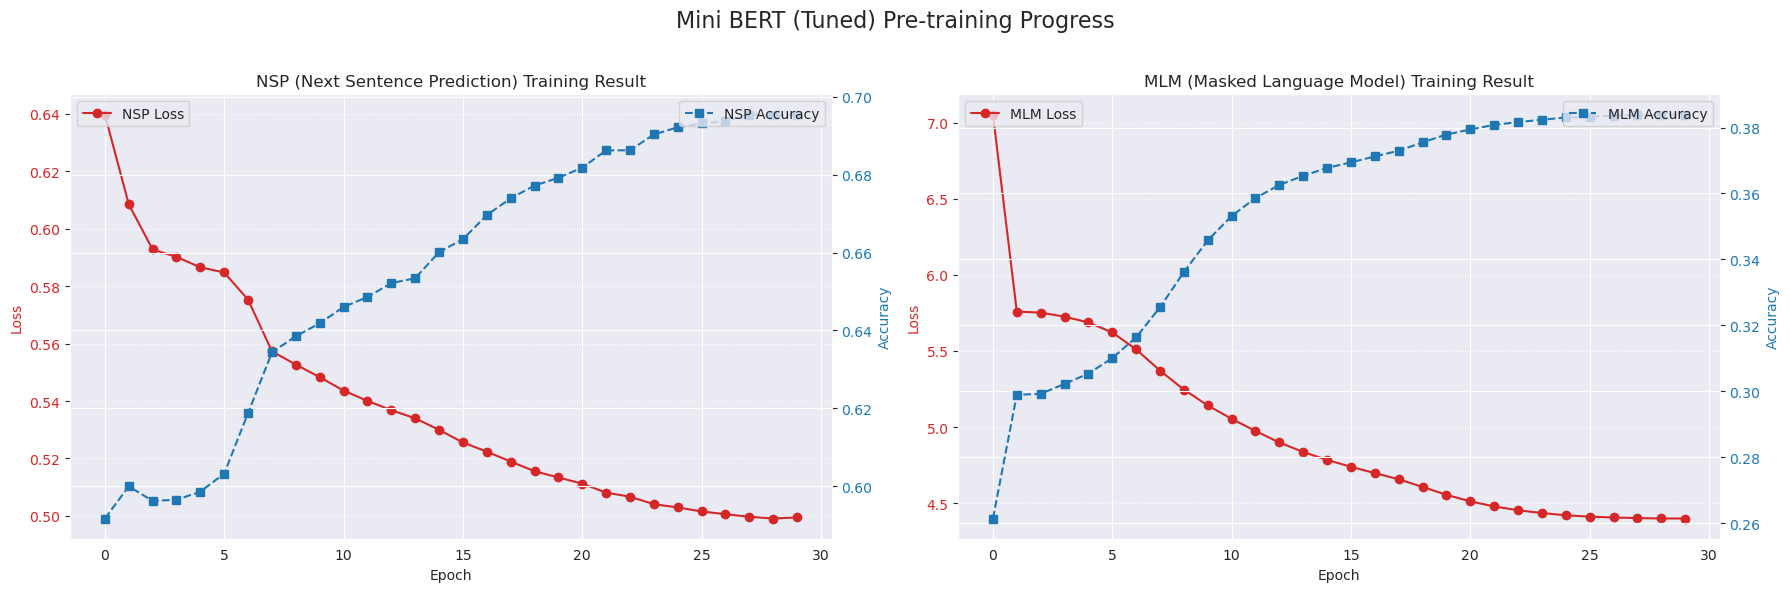

In [19]:
# Visualize results
sns.set_style('darkgrid')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Mini BERT (Tuned) Pre-training Progress', fontsize=16)

# NSP Loss and Accuracy
color_loss = 'tab:red'
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss', color=color_loss)
axes[0].plot(history['nsp_loss'], color=color_loss, marker='o', label='NSP Loss')
axes[0].tick_params(axis='y', labelcolor=color_loss)

ax2 = axes[0].twinx()
color_acc = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color_acc)
ax2.plot(history['nsp_acc'], color=color_acc, marker='s', linestyle='--', label='NSP Accuracy')
ax2.tick_params(axis='y', labelcolor=color_acc)

axes[0].set_title('NSP (Next Sentence Prediction) Training Result')
axes[0].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[0].grid(True, axis='y', linestyle=':')

# MLM Loss and Accuracy
color_loss = 'tab:red'
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss', color=color_loss)
axes[1].plot(history['mlm_loss'], color=color_loss, marker='o', label='MLM Loss')
axes[1].tick_params(axis='y', labelcolor=color_loss)

ax3 = axes[1].twinx()
color_acc = 'tab:blue'
ax3.set_ylabel('Accuracy', color=color_acc)
ax3.plot(history['mlm_acc'], color=color_acc, marker='s', linestyle='--', label='MLM Accuracy')
ax3.tick_params(axis='y', labelcolor=color_acc)

axes[1].set_title('MLM (Masked Language Model) Training Result')
axes[1].legend(loc='upper left')
ax3.legend(loc='upper right')
axes[1].grid(True, axis='y', linestyle=':')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [20]:
# Performance Test Functions
def test_mlm(model, vocab, sentence):
    model.eval()
    tokens = vocab.encode_as_pieces(sentence)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]

    try:
        mask_index = tokens.index("[MASK]")
    except ValueError:
        print("Error: '[MASK]' token not found.")
        return

    enc_tokens = [vocab.piece_to_id(p) for p in tokens]
    segments = [0] * len(enc_tokens)

    input_tokens = torch.tensor([enc_tokens], dtype=torch.long).to(device)
    input_segments = torch.tensor([segments], dtype=torch.long).to(device)

    with torch.no_grad():
        _, logits_mlm, _ = model(input_tokens, input_segments)

    mask_logits = logits_mlm[0, mask_index, :]
    probs = F.softmax(mask_logits, dim=-1)
    top_5_probs, top_5_indices = torch.topk(probs, 5)
    top_5_tokens = [vocab.id_to_piece(idx.item()) for idx in top_5_indices]

    print(f"\nInput: {sentence}")
    print("-" * 30)
    for i in range(5):
        token = top_5_tokens[i].replace(' ', ' ')
        print(f"Top {i+1}: {token} (prob: {top_5_probs[i]:.4f})")
    print("-" * 30)
    predicted_word = top_5_tokens[0].replace(' ', '')
    print(f"Prediction: {sentence.replace('[MASK]', predicted_word)}")

In [21]:
def test_nsp(model, vocab, sent_a, sent_b):
    model.eval()
    tokens_a = vocab.encode_as_pieces(sent_a)
    tokens_b = vocab.encode_as_pieces(sent_b)

    tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
    enc_tokens = [vocab.piece_to_id(p) for p in tokens]
    segments = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

    padding_needed = n_seq - len(enc_tokens)
    if padding_needed > 0:
        enc_tokens.extend([0] * padding_needed)
        segments.extend([0] * padding_needed)

    input_tokens = torch.tensor([enc_tokens], dtype=torch.long).to(device)
    input_segments = torch.tensor([segments], dtype=torch.long).to(device)

    with torch.no_grad():
        logits_nsp, _, _ = model(input_tokens, input_segments)

    probs = F.softmax(logits_nsp, dim=-1)
    is_next_prob = probs[0, 1].item()

    print(f"\nSentence A: {sent_a}")
    print(f"Sentence B: {sent_b}")
    print("-" * 30)
    print(f"Probability that B is the next sentence of A: {is_next_prob:.2%}")
    if is_next_prob > 0.5:
        print("Prediction: YES, it is the next sentence.")
    else:
        print("Prediction: NO, it is not the next sentence.")

In [22]:
import matplotlib.font_manager as fm

# Attention visualization function
def visualize_attention(model, vocab, sentence, layer_idx=-1):
    model.eval()

    tokens = vocab.encode_as_pieces(sentence)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]

    enc_tokens = [vocab.piece_to_id(p) for p in tokens]
    segments = [0] * len(enc_tokens)

    input_tokens = torch.tensor([enc_tokens], dtype=torch.long).to(device)
    input_segments = torch.tensor([segments], dtype=torch.long).to(device)

    with torch.no_grad():
        _, _, attn_probs = model(input_tokens, input_segments)

    attention = attn_probs[layer_idx][0]
    attention_matrix = attention.mean(dim=0).cpu().numpy()

    font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=12)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, 
                annot=True, fmt=".2f", cmap='viridis', ax=ax)
    
    ax.set_title(f'Layer {layer_idx+len(attn_probs) if layer_idx < 0 else layer_idx+1} Attention Heatmap', 
                 fontproperties=fontprop, fontsize=15)
    plt.xticks(fontproperties=fontprop, rotation=45)
    plt.yticks(fontproperties=fontprop)
    
    plt.show()


========== MLM (Fill-in-the-blank) Test ==========

Input: 대한민국의 수도는 [MASK]이다.
------------------------------
Top 1: ▁다음을 (prob: 0.6643)
Top 2: ▁가리키는 (prob: 0.1166)
Top 3: ▁다음 (prob: 0.0678)
Top 4: [UNK] (prob: 0.0272)
Top 5: ▁사람을 (prob: 0.0264)
------------------------------
Prediction: 대한민국의 수도는 ▁다음을이다.

Input: 오늘 점심으로 [MASK]을 먹고 싶다.
------------------------------
Top 1: [UNK] (prob: 0.5122)
Top 2: ▁사람을 (prob: 0.0250)
Top 3: ▁다음과 (prob: 0.0163)
Top 4: ▁것을 (prob: 0.0154)
Top 5: ▁있는 (prob: 0.0123)
------------------------------
Prediction: 오늘 점심으로 [UNK]을 먹고 싶다.

====== NSP (Next Sentence Prediction) Test =======

Sentence A: 오늘 날씨가 정말 좋네요.
Sentence B: 공원에 산책하러 가야겠어요.
------------------------------
Probability that B is the next sentence of A: 51.63%
Prediction: YES, it is the next sentence.

Sentence A: 오늘 날씨가 정말 좋네요.
Sentence B: 저녁에는 짜장면을 먹어야지.
------------------------------
Probability that B is the next sentence of A: 48.83%
Prediction: NO, it is not the next sentence.


/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/c

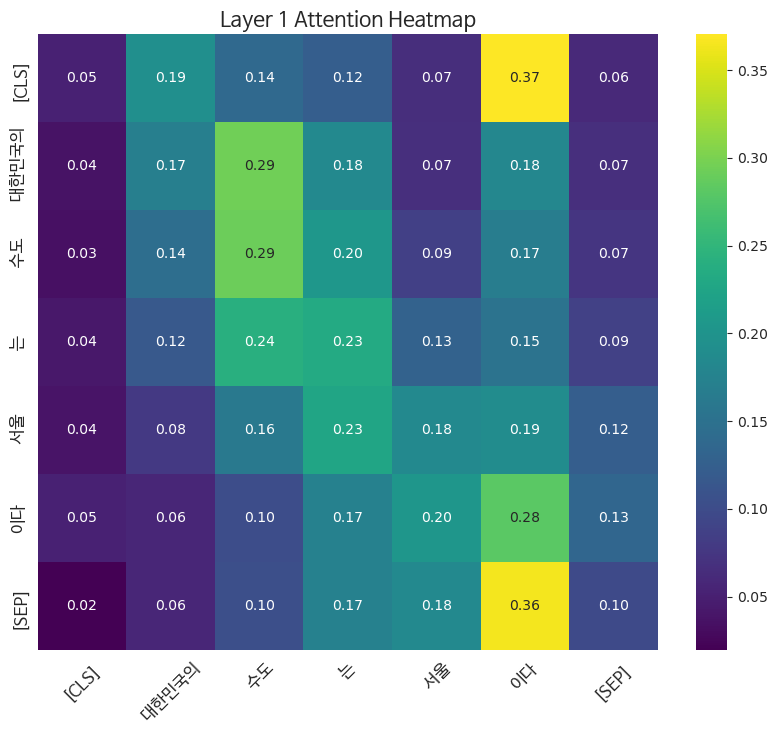

In [23]:
# --- Run tests after training ---
print("\n" + "="*50)
print(" MLM (Fill-in-the-blank) Test ".center(50, "="))
print("="*50)
test_mlm(model, vocab, "대한민국의 수도는 [MASK]이다.")
test_mlm(model, vocab, "오늘 점심으로 [MASK]을 먹고 싶다.")

print("\n" + "="*50)
print(" NSP (Next Sentence Prediction) Test ".center(50, "="))
print("="*50)
test_nsp(model, vocab, "오늘 날씨가 정말 좋네요.", "공원에 산책하러 가야겠어요.")
test_nsp(model, vocab, "오늘 날씨가 정말 좋네요.", "저녁에는 짜장면을 먹어야지.")

# Test attention visualization
test_sentence = "대한민국의 수도는 서울이다"
visualize_attention(model, vocab, test_sentence)